# Unsupervised learning and more complex model structures
- In this notebook we create a convolutional autoencoder model to train in an _unsupervised_ manner
- We also show how to build other models that reuse parts of this convolutional autoencoder in various ways:
    - A second autoencoder that adds fourier (and inverse fourier) transforms to the encoding and decoding steps
    - A small predictor model that is attached onto the already trained endoer layers

- In unsupervised learning we only have the inputs to our function, but no labels/targets/outputs. But we still want to learn a function that gives useful insight to the input data
- Consider the images used previously:
    - they are high dimensional vectors (in $\mathbf{R}^{784}$).
    - However, actual images of handwritten digits is a very small subset of all possible 28*28 images
    - We assume/hypothesise that the dataset x_train exists on some lower dimensional manifold, embedded in $\mathbf{R}^{784}$
    - Can we learn a projection onto that manifold?

In [14]:
import jax
import jax.numpy as np
import jax.random as jr
import optax
import equinox as eqx 
import einops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

In [3]:
SEED = 1234
key = jr.PRNGKey(SEED) # JAX is very explicit with pseudo-random numbers, such that everything can be kept as a "pure" function when needed

## Import the MNIST dataset as before


In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,np.newaxis] / 255.0
x_test = x_test[:,np.newaxis] / 255.0
y_train_1hot = jax.nn.one_hot(y_train,num_classes=10,axis=-1)
y_test_1hot = jax.nn.one_hot(y_test,num_classes=10,axis=-1)

2024-02-22 18:18:27.895188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 18:18:27.895226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 18:18:27.896360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 18:18:28.771821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Lets define a convolutional autoencoder
- Here the `eqx.nn.Conv2D` layers perform 2d convolutions
- `eqx.nn.MaxPool2d` downsamples to smaller images
- `eqx.ConvTranspose2d` upsamples again to higher resolution
- For convenience and clarity we defined `.encode` and `.decode` methods that map to and from the latent space, and the `__call__` method just does an encode followed by a decode
   - If trained properly, encode and decode should be inverses of each other

In [5]:
class Autoencoder(eqx.Module):
    encode_layers: list
    decode_layers: list

    def __init__(self, key,channels=1):
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        # Standard CNN autoencoder - consecutive layers get narrower via MaxPool2d, and the expanded out again via ConvTranspose2d
        # with a small MLP on top.
        self.encode_layers = [
            eqx.nn.Conv2d(channels, 8, kernel_size=6, key=key1),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu,
            eqx.nn.Conv2d(8, 4, kernel_size=5, key=key2),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu,
            eqx.nn.Conv2d(4, 4, kernel_size=4, key=key3),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.leaky_relu
        ]
        self.decode_layers = [
            eqx.nn.ConvTranspose2d(4,4,kernel_size=4,key=key4),
            jax.nn.leaky_relu,
            eqx.nn.ConvTranspose2d(4,8,kernel_size=5,stride=2,key=key5),
            jax.nn.leaky_relu,
            eqx.nn.ConvTranspose2d(8,channels,kernel_size=6,key=key6),
        ]

    def encode(self,x):
        for L in self.encode_layers:
            x = L(x)
        return x
    
    def decode(self,x):
        for L in self.decode_layers:
            x = L(x)
        return x
    def __call__(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x

## We can also add other functions into our model
- `eqx.Modules` are pretty general - we don't have to stick to things in the equinox library
- Lets explore using fast fourier transforms (FFT) as part of the encoding process, and inverse FFTs in the decoder
- We can also use one `eqx.Module` subclass in another, so we can just use the same layers as are in `Autoencoder` and sandwich them between FFT and iFFT

In [6]:
class FFT_Autoencoder(eqx.Module):
    fft_layers: list
    ifft_layers: list
    autoencoder_model: Autoencoder
    def __init__(self,key):
        self.autoencoder_model = Autoencoder(key,channels=2) # Using 2 channels for real and imaginary components
    
        def concat(c):
            re = c.real
            im = c.imag
            return np.concatenate((re,im),axis=0)
    
        def unconcat(re_im):
            c = re_im[0] + re_im[1]*1j
            c = c[np.newaxis]
            return c
        
        self.fft_layers = [np.fft.fft2,
                           lambda x:np.fft.fftshift(x,axes=(-1,-2)),
                           concat]
        self.ifft_layers=[unconcat,
                          lambda x:np.fft.ifftshift(x,axes=(-1,-2)),
                          lambda x:np.fft.irfft2(x,s=(28,28))]

    def encode(self,x):
        for L in self.fft_layers:
            x = L(x)
        x = self.autoencoder_model.encode(x)
        return x
        
    def decode(self,x):
        x = self.autoencoder_model.decode(x)
        for L in self.ifft_layers:
            x = L(x)
        return x

    def __call__(self,x):
        x = self.encode(x)
        x = self.decode(x)
        return x
        
    

## Define a loss function
- Here just a mean square distance will do

In [7]:
@eqx.filter_value_and_grad
def loss_autoencoder(model,X):
    v_model = jax.vmap(model,in_axes=0,out_axes=0)
    pred = v_model(X)
    return np.mean((pred-X)**2)

## Define the training procedure
- This is pretty standard and almost the same as before, except we are only using $X$
- However we are using a `schedule` rather than a fixed `LEARN_RATE` - now the learning rate is gradually reduced during training

In [8]:
def train(model,steps,LEARN_RATE=1e-3,BATCH_SIZE=64):

    schedule = optax.exponential_decay(LEARN_RATE, transition_steps=steps, decay_rate=0.98)
    optim = optax.adam(schedule)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_log = []
    
    @eqx.filter_jit # Wrap this in a filter_jit to speed things up
    def make_step(model,opt_state,X):
        loss_value,grad = loss_autoencoder(model,X)
        updates, opt_state = optim.update(grad, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
   
    train_key = jr.fold_in(key,1)
    for i in tqdm(range(steps)):
        train_key = jr.fold_in(train_key,i)
        # Choose which samples from x_train to fit to this iteration
        inds = jr.choice(train_key,np.arange(60000),(BATCH_SIZE,),replace=False)
        x = x_train[inds]
        
        # Do the actual gradient update
        model, opt_state, train_loss = make_step(model, opt_state, x)
        loss_log.append(train_loss)
        if i%10==0:
            tqdm.write("Loss at step "+str(i)+": "+str(train_loss))
    
    return model,loss_log

### Lets see if adding FFTs as a preprocessing step helped
- We can use the same training code on both models

In [9]:
subkey = jr.fold_in(key,int(time.time()))
key1,key2 = jr.split(subkey)
model = Autoencoder(key1)
model_fft = FFT_Autoencoder(key2)

In [10]:
model_fft_trained,losses_fft = train(model_fft,1000,LEARN_RATE=1e-2,BATCH_SIZE=32)
model_trained,losses = train(model,1000,LEARN_RATE=1e-2,BATCH_SIZE=32)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.11398687
Loss at step 10: 0.106320485
Loss at step 20: 0.101332955
Loss at step 30: 0.086464494
Loss at step 40: 0.076728694
Loss at step 50: 0.073078156
Loss at step 60: 0.06461938
Loss at step 70: 0.06204145
Loss at step 80: 0.0650532
Loss at step 90: 0.06442122
Loss at step 100: 0.062931284
Loss at step 110: 0.056289878
Loss at step 120: 0.06408486
Loss at step 130: 0.0551968
Loss at step 140: 0.05583657
Loss at step 150: 0.06860351
Loss at step 160: 0.05386256
Loss at step 170: 0.060582418
Loss at step 180: 0.060323153
Loss at step 190: 0.057410542
Loss at step 200: 0.05566117
Loss at step 210: 0.0584857
Loss at step 220: 0.055237934
Loss at step 230: 0.05602576
Loss at step 240: 0.05049684
Loss at step 250: 0.053541727
Loss at step 260: 0.057832297
Loss at step 270: 0.05906174
Loss at step 280: 0.06112621
Loss at step 290: 0.049163204
Loss at step 300: 0.0542315
Loss at step 310: 0.05594538
Loss at step 320: 0.050912637
Loss at step 330: 0.05482405
Loss at step 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.11981882
Loss at step 10: 0.077029526
Loss at step 20: 0.06630016
Loss at step 30: 0.06637622
Loss at step 40: 0.06708483
Loss at step 50: 0.06738185
Loss at step 60: 0.060220405
Loss at step 70: 0.056849726
Loss at step 80: 0.058805235
Loss at step 90: 0.060662307
Loss at step 100: 0.05721627
Loss at step 110: 0.051281217
Loss at step 120: 0.05887363
Loss at step 130: 0.049778324
Loss at step 140: 0.048585232
Loss at step 150: 0.057922557
Loss at step 160: 0.047319386
Loss at step 170: 0.04896458
Loss at step 180: 0.049967278
Loss at step 190: 0.0454042
Loss at step 200: 0.04476663
Loss at step 210: 0.049261544
Loss at step 220: 0.043877266
Loss at step 230: 0.046876755
Loss at step 240: 0.042347778
Loss at step 250: 0.042711616
Loss at step 260: 0.045718838
Loss at step 270: 0.044559058
Loss at step 280: 0.048243206
Loss at step 290: 0.040387135
Loss at step 300: 0.041626677
Loss at step 310: 0.042161677
Loss at step 320: 0.040450063
Loss at step 330: 0.04508318
Los

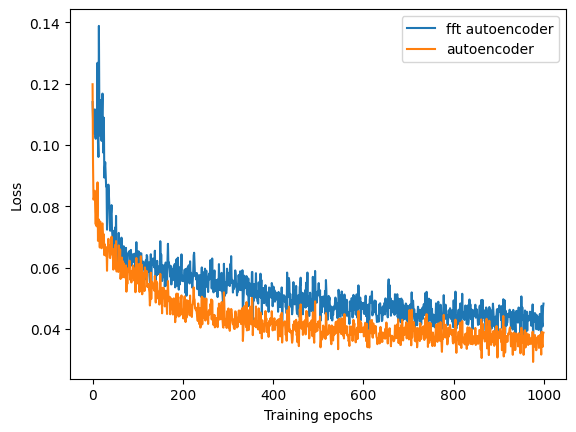

In [23]:
plt.plot(losses_fft,label="fft autoencoder")
plt.plot(losses,label="autoencoder")
plt.legend()
plt.xlabel("Training epochs")
plt.ylabel("Loss")
plt.show()

### How to assess performance?
- the ratio between latent space and input space dimensions acts as a measure of compression ratio
- We can visualise pairs of inputs and outputs of the autoencoders
- We can also visualise aspects of the latent spaces


(4, 7, 7)
Compression ration: 0.25


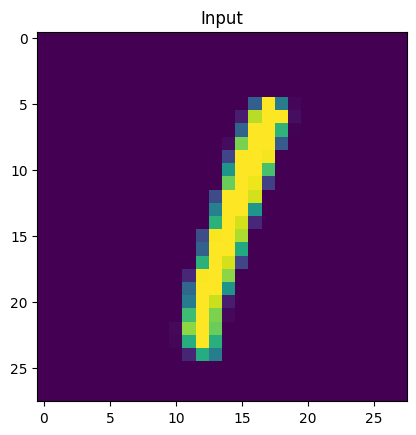

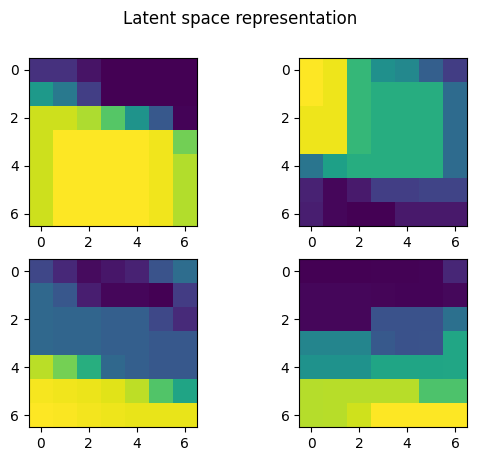

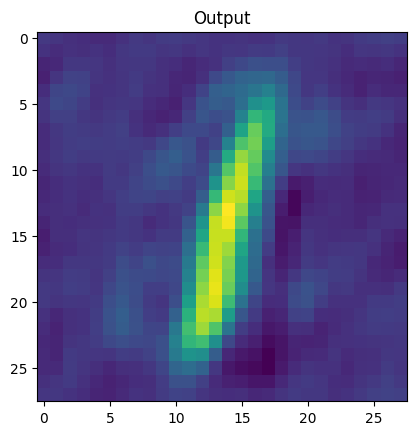

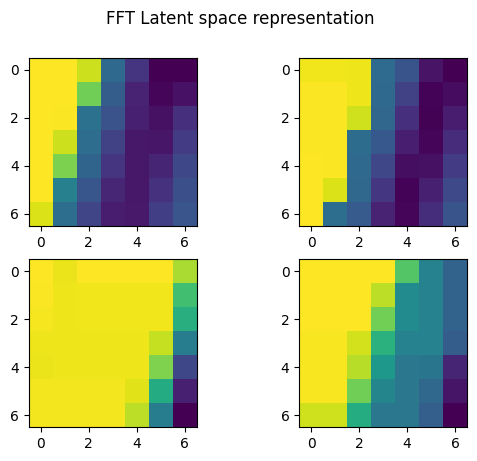

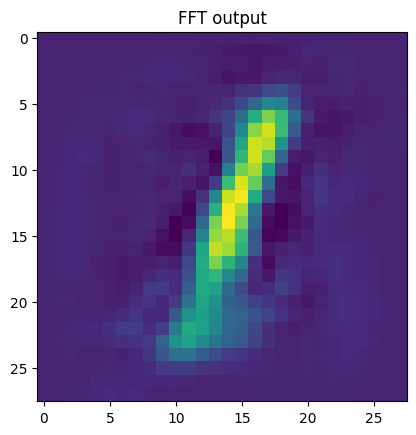

In [22]:

I = 5
embedding = model_fft_trained.encode(x_test[I])
output = model_fft_trained.decode(embedding)

embedding_fft = model_trained.encode(x_test[I])
output_fft = model_trained.decode(embedding_fft)
#print(embedding)
print(embedding.shape)

latent_space = embedding.flatten().shape[0]
input_space = output.flatten().shape[0]

print("Compression ration: "+str(latent_space/input_space))

plt.imshow(x_test[I,0])
plt.title("Input")
plt.show()

fig,ax = plt.subplots(2,2)
ax[0,0].imshow(embedding[0])
ax[0,1].imshow(embedding[1])
ax[1,0].imshow(embedding[2])
ax[1,1].imshow(embedding[3])
fig.suptitle("Latent space representation")
plt.show()

plt.imshow(output[0])
plt.title("Output")
plt.show()


fig,ax = plt.subplots(2,2)
ax[0,0].imshow(embedding_fft[0])
ax[0,1].imshow(embedding_fft[1])
ax[1,0].imshow(embedding_fft[2])
ax[1,1].imshow(embedding_fft[3])
fig.suptitle("FFT Latent space representation")
plt.show()



plt.imshow(output_fft[0])
plt.title("FFT output")
plt.show()

### We can take use the autoencoder to help classify
- Construct a new network that uses the encoder part of a trained autoencoder as the first few layers
- `equinox` lets us be flexible and precise with which weights are actually learned - we can _freeze_ the already trained encoder weights and just learn a predictor on the last few layers
    - This is done with the `eqx.partition` and `eqx.combine` functions
    - Each `eqx.Module` is stored as a PyTree - basically a list of different python objects (lists, arrays, functions etc.)
    - `eqx.partition` splits a Pytree into two depending on a boolean condition. Useful for defining which parts of the PyTree are to be modified by training
    - `eqx.combine` does the opposite - it combines two PyTrees together

In [30]:
class EncodePredict(eqx.Module):
    
    autoencoder_model: Autoencoder
    layers: list

    def __init__(self,autoencoder,key,channels=1):
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        self.autoencoder_model = autoencoder
        self.layers = [
            np.ravel,
            eqx.nn.Linear(196,64,key=key1),
            jax.nn.leaky_relu,
            eqx.nn.Linear(64,10,key=key2),
            jax.nn.softmax
        ]
    
    def __call__(self,x):

        x = self.autoencoder_model.encode(x)
        
        for L in self.layers:
            x = L(x)
        return x
    
    def partition(self):
        # Condition that selects the autoencoder model
        where = lambda model: model.autoencoder_model 
        
        # Initially split based on what is an array - eqx.filter_grad already does this by default
        diff,static = eqx.partition(self,eqx.is_array)

        # Set the autoencoder parts of diff to None
        diff = eqx.tree_at(where,diff,None)

        # Store the autoencoder part into static
        static = eqx.tree_at(where,static,self.autoencoder_model,is_leaf=lambda x: x is None)
        return diff, static
    
    def combine(self,diff,static):
        self = eqx.combine(diff,static)


### Partitioning and combining
 - To understand what `eqx.combine` and `eqx.partition` do, print them and compare to the full model
 - Notice that the `diff` model is much smaller than the `static` one. We are only training very few parameters now, so this part of training should be fast

In [31]:
epnn = EncodePredict(model_trained,key)
diff,static = epnn.partition()
print(epnn)
print("=======================================================")
print(diff)
print("=======================================================")
print(static)



EncodePredict(
  autoencoder_model=Autoencoder(
    encode_layers=[
      Conv2d(
        num_spatial_dims=2,
        weight=f32[8,1,6,6],
        bias=f32[8,1,1],
        in_channels=1,
        out_channels=8,
        kernel_size=(6, 6),
        stride=(1, 1),
        padding=((0, 0), (0, 0)),
        dilation=(1, 1),
        groups=1,
        use_bias=True
      ),
      MaxPool2d(
        init=-inf,
        operation=<function max>,
        num_spatial_dims=2,
        kernel_size=(4, 4),
        stride=(1, 1),
        padding=((0, 0), (0, 0)),
        use_ceil=False
      ),
      <wrapped function leaky_relu>,
      Conv2d(
        num_spatial_dims=2,
        weight=f32[4,8,5,5],
        bias=f32[4,1,1],
        in_channels=8,
        out_channels=4,
        kernel_size=(5, 5),
        stride=(1, 1),
        padding=((0, 0), (0, 0)),
        dilation=(1, 1),
        groups=1,
        use_bias=True
      ),
      MaxPool2d(
        init=-inf,
        operation=<function max>,
      

## Define the loss function
 - The only difference here is we pass `model_diff` and `model_static` seperately. 
 - As `grad` functions in JAX compute gradients with respect to the first input to a function, only the parameters in `model_diff` are considered in the gradient computation

In [32]:
@eqx.filter_value_and_grad
def loss_cross_entropy(model_diff,model_static,x,y):
    model = eqx.combine(model_diff,model_static)
    v_model = jax.vmap(model,in_axes=0,out_axes=0)
    y_predicted = v_model(x)
    return -np.mean(y*np.log(y_predicted))


## Define the train method
 - Here in the `make_step` method we call the `model.partition` to split into the differentiable and the constant part

In [33]:
def train_predictor(model,steps,LEARN_RATE=1e-3,BATCH_SIZE=32):

    optim = optax.adam(LEARN_RATE)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_log = []
    
    @eqx.filter_jit # Wrap this in a filter_jit to speed things up
    def make_step(model,opt_state,x,y):
        model_diff,model_static = model.partition()
        loss_value,grad = loss_cross_entropy(model_diff,model_static,x,y)
        updates, opt_state = optim.update(grad, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
   
    train_key = jr.fold_in(key,1)
    for i in tqdm(range(steps)):
        train_key = jr.fold_in(train_key,i)
        # Choose which samples from x_train to fit to this iteration
        inds = jr.choice(train_key,np.arange(60000),(BATCH_SIZE,),replace=False)
        x = x_train[inds]
        y = y_train_1hot[inds]
        
        # Do the actual gradient update
        model, opt_state, train_loss = make_step(model, opt_state, x,y)
        loss_log.append(train_loss)
        if i%10==0:
            tqdm.write("Loss at step "+str(i)+": "+str(train_loss))
    
    return model,loss_log

In [34]:
predictor,loss_log = train_predictor(epnn,1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.22817536
Loss at step 10: 0.2171688
Loss at step 20: 0.20821519
Loss at step 30: 0.19237886
Loss at step 40: 0.18354568
Loss at step 50: 0.16262849
Loss at step 60: 0.14195842
Loss at step 70: 0.13718228
Loss at step 80: 0.11854874
Loss at step 90: 0.13621627
Loss at step 100: 0.11206031
Loss at step 110: 0.09900737
Loss at step 120: 0.11664393
Loss at step 130: 0.08913846
Loss at step 140: 0.10090077
Loss at step 150: 0.0985875
Loss at step 160: 0.07700138
Loss at step 170: 0.084124155
Loss at step 180: 0.07938399
Loss at step 190: 0.05788228
Loss at step 200: 0.06827762
Loss at step 210: 0.06897552
Loss at step 220: 0.08665692
Loss at step 230: 0.082271256
Loss at step 240: 0.090846255
Loss at step 250: 0.07550182
Loss at step 260: 0.06637333
Loss at step 270: 0.06988431
Loss at step 280: 0.08331191
Loss at step 290: 0.068026714
Loss at step 300: 0.080846354
Loss at step 310: 0.07175769
Loss at step 320: 0.08886787
Loss at step 330: 0.072361425
Loss at step 340: 0.0

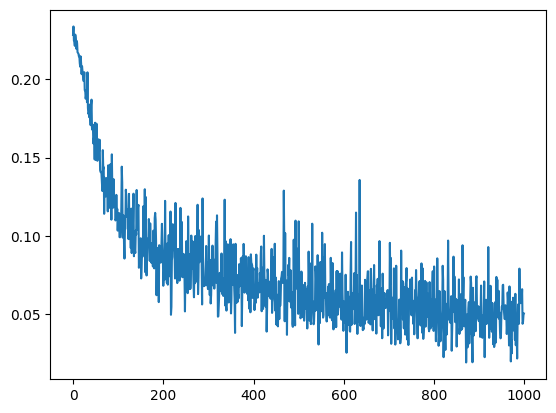

In [35]:
plt.plot(loss_log)

In [37]:
y_test_predictions = np.argmax(jax.vmap(predictor)(x_test),axis=1) # By taking the maximum of the output probability distribution, we are forcing the model to discretely choose a number
confusion_matrix = np.zeros((10,10))
for i in range(len(y_test)):
    confusion_matrix = confusion_matrix.at[y_test[i],y_test_predictions[i]].set(confusion_matrix[y_test[i],y_test_predictions[i]]+1)



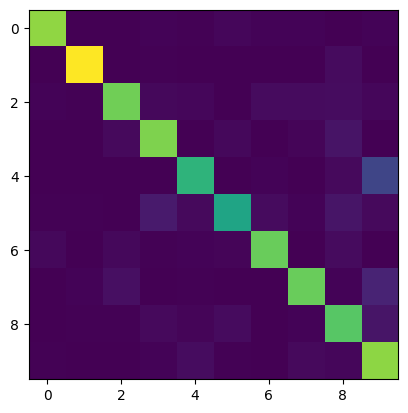

In [38]:
plt.imshow(confusion_matrix)